# ViT 이미지 분류기 훈련 및 시각화 노트북

이 노트북은 Hugging Face의 Vision Transformer (ViT) 모델을 사용하여 CIFAR-10 데이터셋에서 이미지 분류를 수행하고, 훈련 과정과 결과를 상세히 시각화합니다.

## 주요 기능
- 📈 **훈련 과정 모니터링**: 손실과 정확도의 실시간 시각화
- 🎯 **성능 평가**: 혼동행렬, 클래스별 성능 분석
- 🖼️ **예측 결과 시각화**: 올바른/잘못된 예측 샘플 표시
- 📊 **대화형 그래프**: matplotlib과 seaborn을 활용한 시각화

## 1. 필수 라이브러리 Import

In [16]:
# 기본 라이브러리
import os
import json
import time
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# 데이터 처리
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

# 딥러닝 및 모델 관련
import torch
import torch.nn as nn
from transformers import (
    ViTImageProcessor, 
    ViTForImageClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from datasets import load_dataset, Dataset

# 이미지 처리
from PIL import Image

# 시각화
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.animation import FuncAnimation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 평가 메트릭
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    precision_recall_fscore_support
)

# 스타일 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎉 모든 라이브러리가 성공적으로 Import되었습니다!")
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA 버전: {torch.version.cuda}")
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")

🎉 모든 라이브러리가 성공적으로 Import되었습니다!
PyTorch 버전: 2.4.1+cu121
CUDA 사용 가능: True
CUDA 버전: 12.1
GPU 이름: Quadro RTX 4000


## 2. 향상된 ViT 분류기 클래스 정의

훈련 과정을 추적하고 시각화하기 위한 커스텀 콜백과 함께 ViT 분류기를 정의합니다.

In [5]:
class MetricsCallback(TrainerCallback):
    """훈련 과정의 메트릭을 추적하는 콜백"""
    
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.learning_rates = []
        self.steps = []
        self.epochs = []
        
    def on_log(self, args, state, control, model=None, logs=None, **kwargs):
        """로그 발생시 메트릭 저장"""
        if logs:
            if 'train_loss' in logs:
                self.train_losses.append(logs['train_loss'])
                self.steps.append(state.global_step)
                
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
                
            if 'eval_accuracy' in logs:
                self.eval_accuracies.append(logs['eval_accuracy'])
                
            if 'learning_rate' in logs:
                self.learning_rates.append(logs['learning_rate'])
                
    def on_epoch_end(self, args, state, control, model=None, **kwargs):
        """에포크 종료시 기록"""
        self.epochs.append(state.epoch)

class EnhancedViTClassifier:
    """시각화 기능이 강화된 ViT 분류기"""
    
    def __init__(
        self, 
        model_name: str = "google/vit-base-patch16-224",
        num_labels: int = 10,
        output_dir: str = "./notebook_results"
    ):
        self.model_name = model_name
        self.num_labels = num_labels
        self.output_dir = output_dir
        
        # 클래스 이름 초기화
        self.class_names = [
            "airplane", "automobile", "bird", "cat", "deer",
            "dog", "frog", "horse", "ship", "truck"
        ]
        
        # 프로세서와 모델 초기화
        print("🔄 모델 로딩 중...")
        self.processor = ViTImageProcessor.from_pretrained(model_name)
        self.model = ViTForImageClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
        
        # 디바이스 설정
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        # 메트릭 콜백 초기화
        self.metrics_callback = MetricsCallback()
        
        # 결과 저장 디렉토리 생성
        os.makedirs(self.output_dir, exist_ok=True)
        
        print(f"✅ 모델이 {self.device}에 로드되었습니다.")
        print(f"📊 모델 파라미터 수: {sum(p.numel() for p in self.model.parameters()):,}")
        
    def prepare_dataset(self, dataset_name: str = "cifar10", subset_size: Optional[int] = None):
        """데이터셋 준비 및 전처리"""
        print(f"📂 {dataset_name} 데이터셋 로드 중...")
        
        # 데이터셋 로드
        dataset = load_dataset(dataset_name)
        
        # 클래스 이름 업데이트
        self.class_names = dataset["train"].features["label"].names
        print(f"🏷️  클래스: {self.class_names}")
        
        def preprocess_images(examples):
            """이미지 전처리 함수"""
            images = [img.convert("RGB") for img in examples["img"]]
            inputs = self.processor(images, return_tensors="pt")
            inputs["labels"] = examples["label"]
            return inputs
        
        # 데이터셋 전처리
        train_dataset = dataset["train"].with_transform(preprocess_images)
        test_dataset = dataset["test"].with_transform(preprocess_images)
        
        # 서브셋 생성 (지정된 경우)
        if subset_size:
            print(f"🔧 서브셋 생성: 훈련 {subset_size}, 테스트 {min(500, len(test_dataset))}개 샘플")
            train_dataset = train_dataset.select(range(min(subset_size, len(train_dataset))))
            test_dataset = test_dataset.select(range(min(500, len(test_dataset))))
        
        print(f"📈 훈련 데이터: {len(train_dataset)} 샘플")
        print(f"📊 테스트 데이터: {len(test_dataset)} 샘플")
        
        return train_dataset, test_dataset
    
    def compute_metrics(self, eval_pred):
        """평가 메트릭 계산"""
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        accuracy = accuracy_score(labels, predictions)
        return {"accuracy": accuracy}

# 분류기 초기화
print("🚀 EnhancedViTClassifier 초기화 중...")
classifier = EnhancedViTClassifier(
    model_name="google/vit-base-patch16-224",
    num_labels=10,
    output_dir="./notebook_results"
)
print("✅ 분류기 초기화 완료!")

🚀 EnhancedViTClassifier 초기화 중...
🔄 모델 로딩 중...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ 모델이 cuda에 로드되었습니다.
📊 모델 파라미터 수: 85,806,346
✅ 분류기 초기화 완료!


## 3. 데이터셋 로드 및 샘플 시각화

📂 cifar10 데이터셋 로드 중...
🏷️  클래스: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
🔧 서브셋 생성: 훈련 2000, 테스트 500개 샘플
📈 훈련 데이터: 2000 샘플
📊 테스트 데이터: 500 샘플

📋 데이터셋 정보:
   클래스 수: 10
   클래스 이름: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck


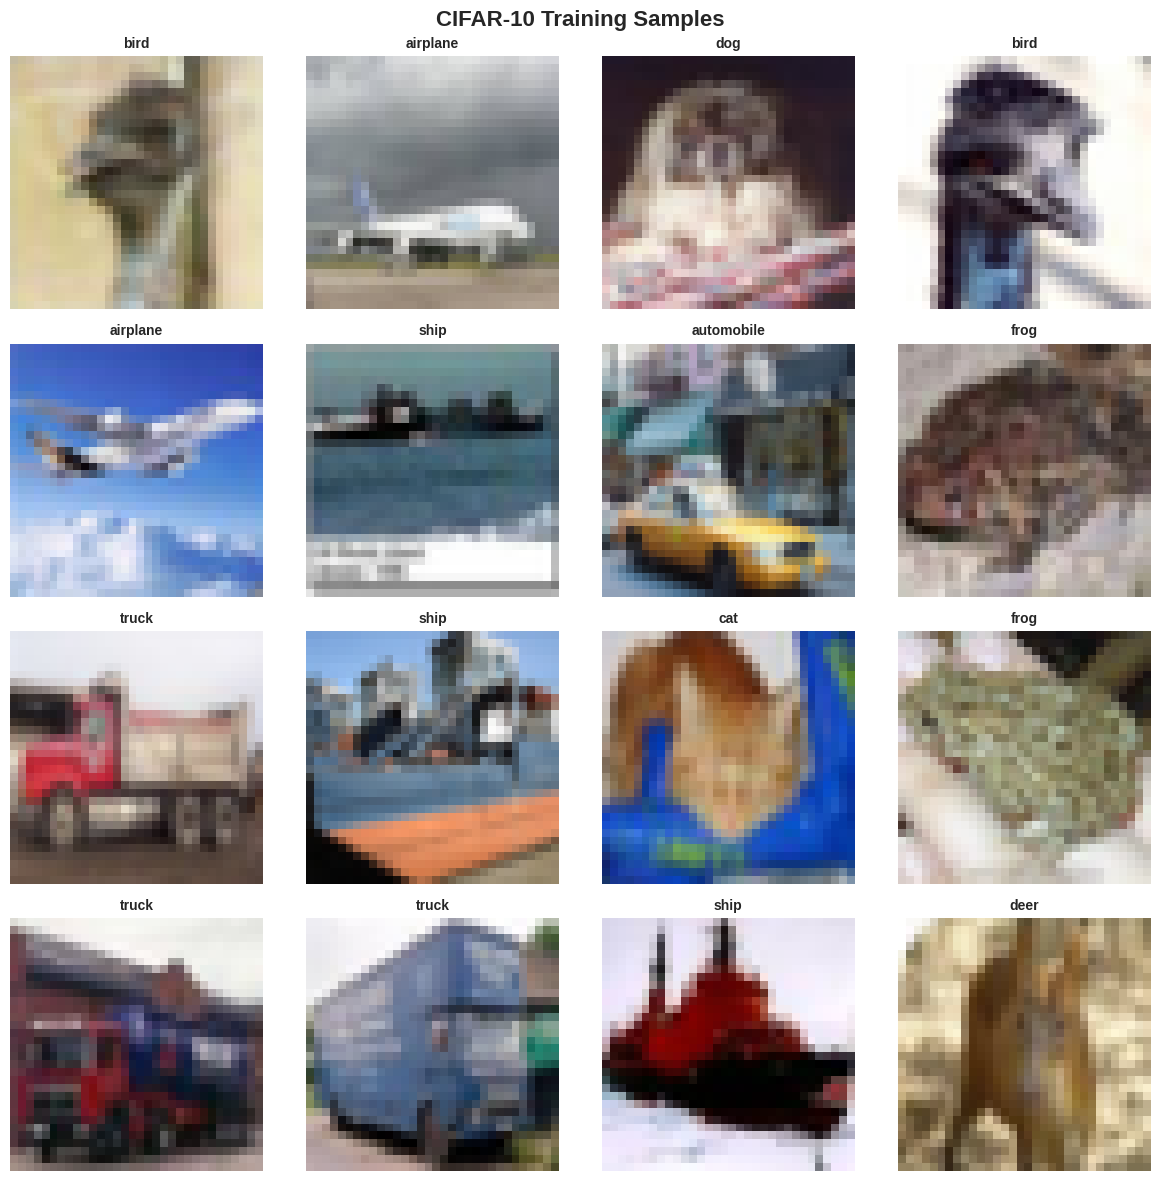

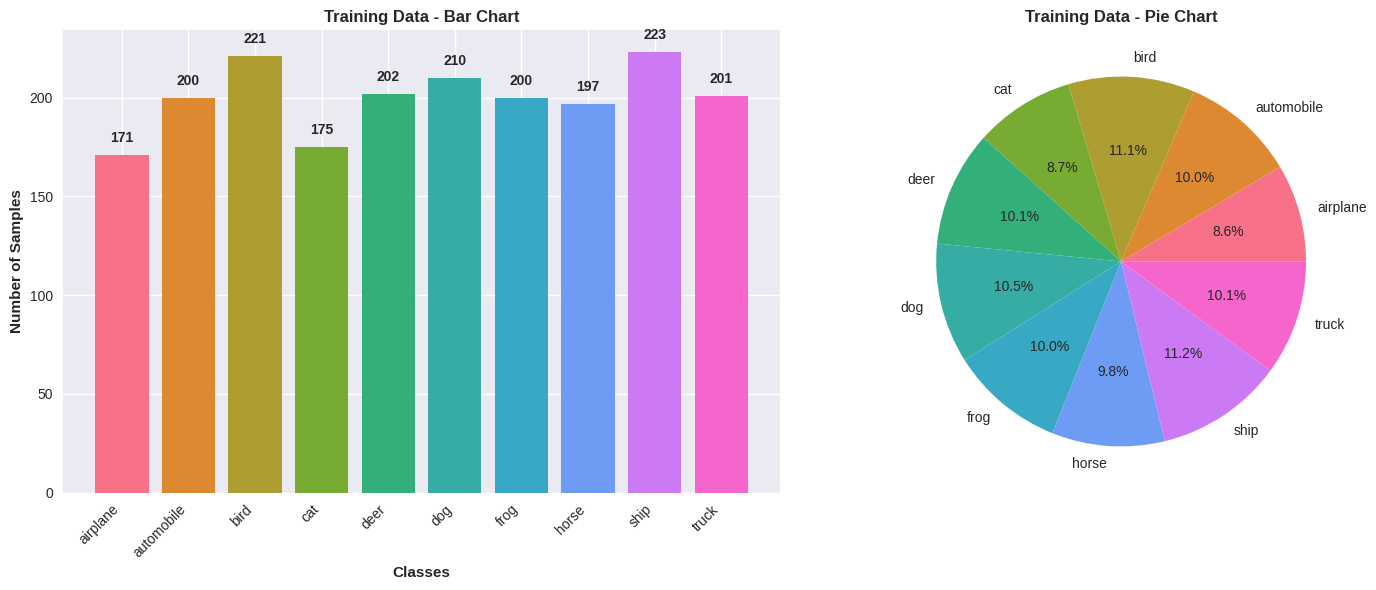

In [6]:
# 데이터셋 준비 (빠른 실험을 위해 서브셋 사용)
train_dataset, test_dataset = classifier.prepare_dataset("cifar10", subset_size=2000)

print(f"\n📋 데이터셋 정보:")
print(f"   클래스 수: {len(classifier.class_names)}")
print(f"   클래스 이름: {', '.join(classifier.class_names)}")

# 데이터셋 샘플 시각화
def visualize_dataset_samples(dataset, class_names, num_samples=16, title="Dataset Samples"):
    """데이터셋 샘플들을 시각화"""
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # 원본 데이터셋에서 랜덤 샘플 선택
    original_dataset = load_dataset("cifar10")["train"]
    indices = np.random.choice(len(original_dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        row, col = i // 4, i % 4
        
        # 원본 이미지와 라벨 가져오기
        sample = original_dataset[int(idx)]
        image = sample["img"]
        label = sample["label"]
        
        axes[row, col].imshow(image)
        axes[row, col].set_title(f"{class_names[label]}", fontsize=10, fontweight='bold')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# 훈련 데이터 샘플 시각화
sample_fig = visualize_dataset_samples(
    train_dataset, 
    classifier.class_names, 
    title="CIFAR-10 Training Samples"
)

# 클래스 분포 시각화
def plot_class_distribution(dataset, class_names, title="Class Distribution"):
    """클래스 분포를 시각화"""
    # 원본 데이터셋에서 라벨 추출
    original_dataset = load_dataset("cifar10")["train"]
    labels = [sample["label"] for sample in original_dataset.select(range(len(dataset)))]
    
    # 클래스 개수 계산
    class_counts = pd.Series(labels).value_counts().sort_index()
    
    # 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 막대 그래프
    bars = ax1.bar(range(len(class_names)), class_counts.values, 
                   color=sns.color_palette("husl", len(class_names)))
    ax1.set_xlabel('Classes', fontweight='bold')
    ax1.set_ylabel('Number of Samples', fontweight='bold')
    ax1.set_title(f'{title} - Bar Chart', fontweight='bold')
    ax1.set_xticks(range(len(class_names)))
    ax1.set_xticklabels(class_names, rotation=45, ha='right')
    
    # 값 표시
    for bar, count in zip(bars, class_counts.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    # 파이 차트
    ax2.pie(class_counts.values, labels=class_names, autopct='%1.1f%%', 
            colors=sns.color_palette("husl", len(class_names)))
    ax2.set_title(f'{title} - Pie Chart', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# 클래스 분포 시각화
dist_fig = plot_class_distribution(train_dataset, classifier.class_names, "Training Data")

## 4. 메트릭 추적이 가능한 모델 훈련

실시간으로 손실과 정확도를 추적하며 모델을 훈련합니다.

In [7]:
# 훈련 설정
training_config = {
    "num_epochs": 3,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "eval_steps": 100,
    "logging_steps": 50,
    "save_steps": 200
}

print("🎯 훈련 설정:")
for key, value in training_config.items():
    print(f"   {key}: {value}")

# 훈련 인자 설정
training_args = TrainingArguments(
    output_dir=classifier.output_dir,
    num_train_epochs=training_config["num_epochs"],
    per_device_train_batch_size=training_config["batch_size"],
    per_device_eval_batch_size=training_config["batch_size"],
    learning_rate=training_config["learning_rate"],
    warmup_steps=100,
    logging_dir=f"{classifier.output_dir}/logs",
    logging_steps=training_config["logging_steps"],
    eval_steps=training_config["eval_steps"],
    save_steps=training_config["save_steps"],
    eval_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to=None,
    remove_unused_columns=False,
    dataloader_pin_memory=False,  # 메모리 사용량 최적화
)

# Trainer 초기화
trainer = Trainer(
    model=classifier.model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=classifier.compute_metrics,
    callbacks=[classifier.metrics_callback]
)

print(f"\n🚀 훈련 시작!")
print(f"   💻 디바이스: {classifier.device}")
print(f"   📊 훈련 샘플: {len(train_dataset)}")
print(f"   🧪 평가 샘플: {len(test_dataset)}")
print(f"   🔄 예상 스텝 수: {len(train_dataset) // training_config['batch_size'] * training_config['num_epochs']}")

# 훈련 시작 시간 기록
start_time = time.time()

# 훈련 실행
trainer.train()

# 훈련 종료 시간 기록
end_time = time.time()
training_time = end_time - start_time

print(f"\n✅ 훈련 완료!")
print(f"   ⏱️  총 훈련 시간: {training_time/60:.2f}분")
print(f"   📈 수집된 훈련 손실: {len(classifier.metrics_callback.train_losses)}개 포인트")
print(f"   📊 수집된 평가 메트릭: {len(classifier.metrics_callback.eval_accuracies)}개 포인트")

# 훈련 히스토리 저장
training_history = {
    'train_losses': classifier.metrics_callback.train_losses,
    'eval_losses': classifier.metrics_callback.eval_losses,
    'eval_accuracies': classifier.metrics_callback.eval_accuracies,
    'learning_rates': classifier.metrics_callback.learning_rates,
    'steps': classifier.metrics_callback.steps,
    'epochs': classifier.metrics_callback.epochs,
    'training_time': training_time,
    'config': training_config
}

# JSON으로 저장
with open(f"{classifier.output_dir}/training_history.json", "w") as f:
    json.dump(training_history, f, indent=2)

print(f"💾 훈련 히스토리가 저장되었습니다: {classifier.output_dir}/training_history.json")

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


🎯 훈련 설정:
   num_epochs: 3
   batch_size: 16
   learning_rate: 2e-05
   eval_steps: 100
   logging_steps: 50
   save_steps: 200

🚀 훈련 시작!
   💻 디바이스: cuda
   📊 훈련 샘플: 2000
   🧪 평가 샘플: 500
   🔄 예상 스텝 수: 375


 13%|█▎        | 50/375 [00:18<02:01,  2.67it/s]

{'loss': 2.2695, 'grad_norm': 7.416806221008301, 'learning_rate': 1e-05, 'epoch': 0.4}


 27%|██▋       | 100/375 [00:37<01:45,  2.61it/s]

{'loss': 1.5725, 'grad_norm': 5.964336395263672, 'learning_rate': 2e-05, 'epoch': 0.8}


                                                 
 27%|██▋       | 100/375 [00:42<01:45,  2.61it/s]

{'eval_loss': 1.106118083000183, 'eval_accuracy': 0.826, 'eval_runtime': 4.3702, 'eval_samples_per_second': 114.411, 'eval_steps_per_second': 7.322, 'epoch': 0.8}


 40%|████      | 150/375 [01:01<01:27,  2.57it/s]

{'loss': 0.6541, 'grad_norm': 4.766904830932617, 'learning_rate': 1.6363636363636366e-05, 'epoch': 1.2}


 53%|█████▎    | 200/375 [01:21<01:09,  2.53it/s]

{'loss': 0.2329, 'grad_norm': 2.9690582752227783, 'learning_rate': 1.2727272727272728e-05, 'epoch': 1.6}


                                                 
 53%|█████▎    | 200/375 [01:25<01:09,  2.53it/s]

{'eval_loss': 0.21924637258052826, 'eval_accuracy': 0.97, 'eval_runtime': 4.4682, 'eval_samples_per_second': 111.901, 'eval_steps_per_second': 7.162, 'epoch': 1.6}


 67%|██████▋   | 250/375 [01:46<00:48,  2.57it/s]

{'loss': 0.1401, 'grad_norm': 3.1721348762512207, 'learning_rate': 9.090909090909091e-06, 'epoch': 2.0}


 80%|████████  | 300/375 [02:06<00:30,  2.44it/s]

{'loss': 0.0511, 'grad_norm': 0.24302814900875092, 'learning_rate': 5.4545454545454545e-06, 'epoch': 2.4}


                                                 
 80%|████████  | 300/375 [02:11<00:30,  2.44it/s]

{'eval_loss': 0.14170844852924347, 'eval_accuracy': 0.964, 'eval_runtime': 4.5934, 'eval_samples_per_second': 108.852, 'eval_steps_per_second': 6.967, 'epoch': 2.4}


 93%|█████████▎| 350/375 [02:32<00:10,  2.42it/s]

{'loss': 0.0371, 'grad_norm': 0.3263832628726959, 'learning_rate': 1.8181818181818183e-06, 'epoch': 2.8}


100%|██████████| 375/375 [02:43<00:00,  2.29it/s]

{'train_runtime': 163.749, 'train_samples_per_second': 36.641, 'train_steps_per_second': 2.29, 'train_loss': 0.6637279885609945, 'epoch': 3.0}

✅ 훈련 완료!
   ⏱️  총 훈련 시간: 2.73분
   📈 수집된 훈련 손실: 1개 포인트
   📊 수집된 평가 메트릭: 3개 포인트
💾 훈련 히스토리가 저장되었습니다: ./notebook_results/training_history.json


## 5. 훈련 과정 시각화

훈련 중 수집된 메트릭을 다양한 방식으로 시각화합니다.

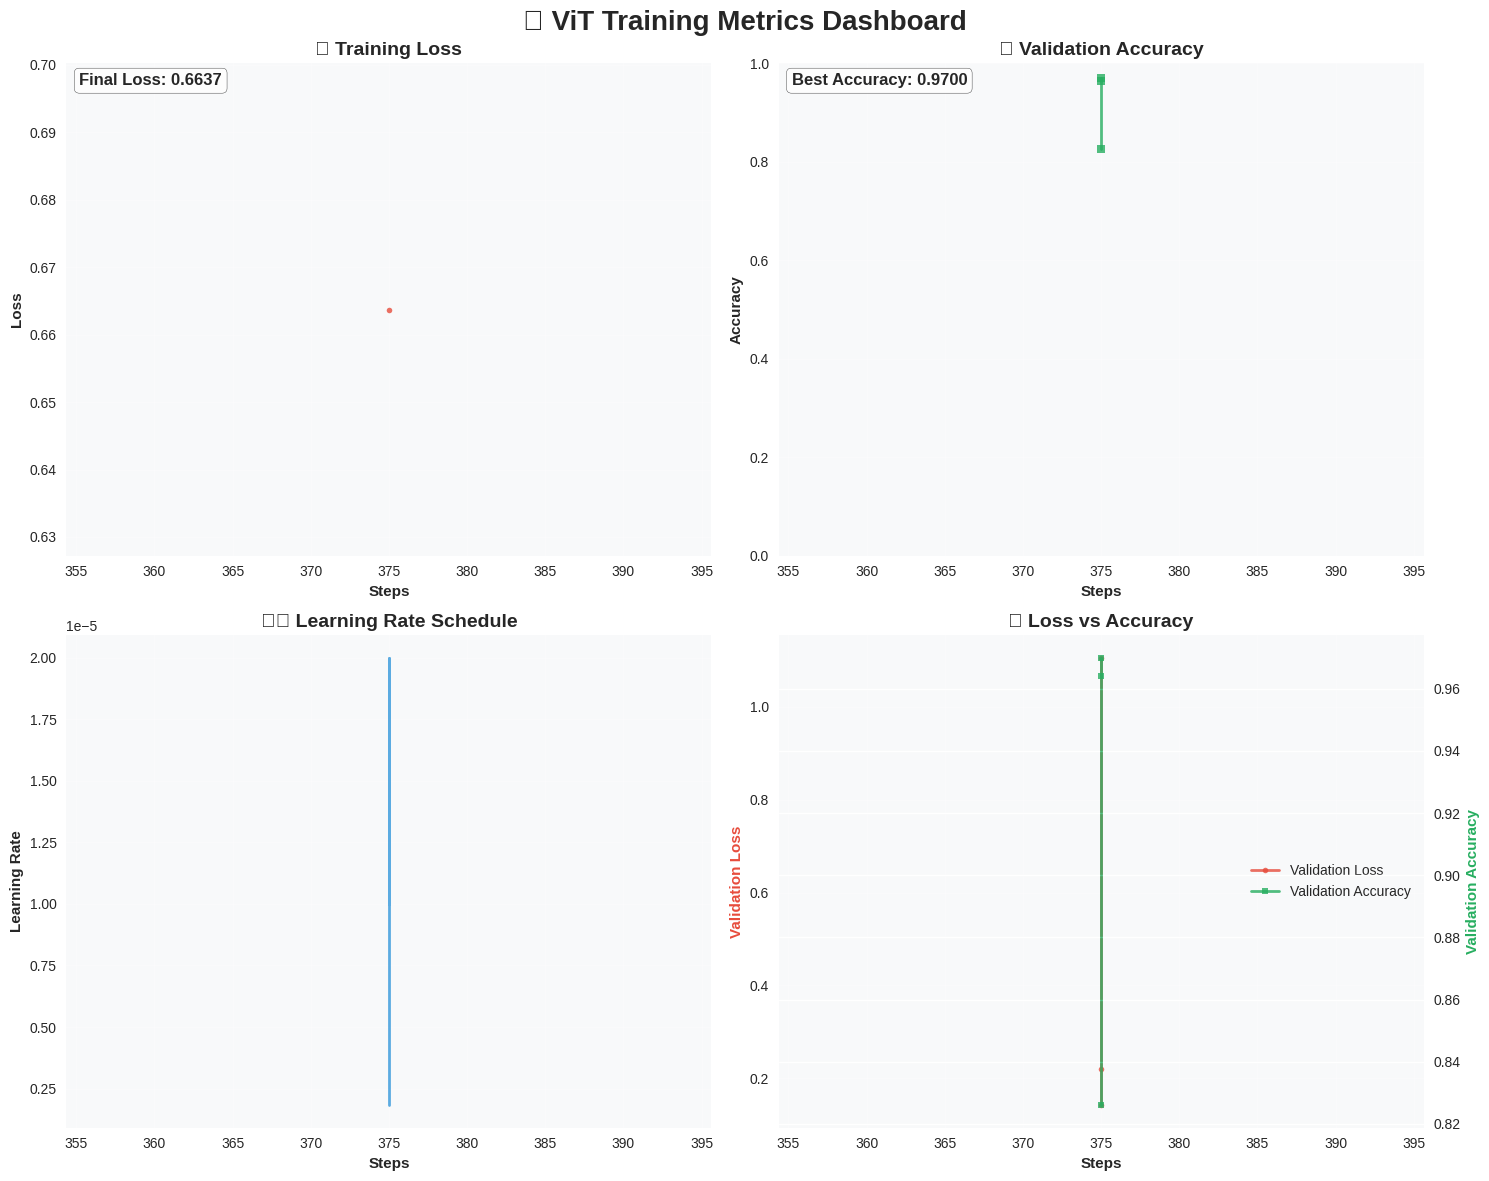

\n============================================================
🎯 TRAINING SUMMARY
📊 Total Training Steps: 1
⏱️  Training Time: 2.73 minutes
🎯 Final Training Loss: 0.6637
📈 Best Validation Accuracy: 0.9700
📉 Final Validation Loss: 0.1417
🎛️  Final Learning Rate: 1.82e-06


In [10]:
def plot_training_metrics(history, save_path=None):
    """훈련 메트릭을 종합적으로 시각화"""
    
    # 서브플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🎯 ViT Training Metrics Dashboard', fontsize=20, fontweight='bold', y=0.98)
    
    # 1. 훈련 손실 (Train Loss)
    if history['train_losses'] and history['steps']:
        axes[0, 0].plot(history['steps'], history['train_losses'], 
                       color='#e74c3c', linewidth=2, marker='o', markersize=4, alpha=0.8)
        axes[0, 0].set_title('📉 Training Loss', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Steps', fontweight='bold')
        axes[0, 0].set_ylabel('Loss', fontweight='bold')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_facecolor('#f8f9fa')
        
        # 최종 손실 표시
        final_loss = history['train_losses'][-1]
        axes[0, 0].text(0.02, 0.98, f'Final Loss: {final_loss:.4f}', 
                       transform=axes[0, 0].transAxes, fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                       verticalalignment='top')
    
    # 2. 평가 정확도 (Validation Accuracy)
    if history['eval_accuracies']:
        # 안전한 스텝 계산
        if len(history['eval_accuracies']) > 0 and len(history['steps']) > 0:
            if len(history['eval_accuracies']) <= len(history['steps']):
                step_interval = max(1, len(history['steps']) // len(history['eval_accuracies']))
                eval_steps = history['steps'][::step_interval][:len(history['eval_accuracies'])]
            else:
                # eval_accuracies가 더 많은 경우, 균등하게 분배
                eval_steps = np.linspace(history['steps'][0], history['steps'][-1], len(history['eval_accuracies']))
        else:
            eval_steps = list(range(len(history['eval_accuracies'])))
            
        axes[0, 1].plot(eval_steps, history['eval_accuracies'], 
                       color='#27ae60', linewidth=2, marker='s', markersize=6, alpha=0.8)
        axes[0, 1].set_title('📈 Validation Accuracy', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Steps', fontweight='bold')
        axes[0, 1].set_ylabel('Accuracy', fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_facecolor('#f8f9fa')
        axes[0, 1].set_ylim([0, 1])
        
        # 최고 정확도 표시
        max_acc = max(history['eval_accuracies'])
        axes[0, 1].text(0.02, 0.98, f'Best Accuracy: {max_acc:.4f}', 
                       transform=axes[0, 1].transAxes, fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                       verticalalignment='top')
    
    # 3. 학습률 스케줄 (Learning Rate Schedule)
    if history['learning_rates'] and history['steps']:
        # 안전한 스텝과 학습률 매칭
        lr_data = history['learning_rates']
        steps_data = history['steps']
        
        # 길이 맞추기
        if len(lr_data) <= len(steps_data):
            # learning_rates가 더 적거나 같은 경우
            step_interval = max(1, len(steps_data) // len(lr_data))
            matched_steps = steps_data[::step_interval][:len(lr_data)]
        else:
            # learning_rates가 더 많은 경우
            matched_steps = np.linspace(steps_data[0] if steps_data else 0, 
                                      steps_data[-1] if steps_data else len(lr_data)-1, 
                                      len(lr_data))
        
        axes[1, 0].plot(matched_steps, lr_data, 
                       color='#3498db', linewidth=2, alpha=0.8)
        axes[1, 0].set_title('🎛️ Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Steps', fontweight='bold')
        axes[1, 0].set_ylabel('Learning Rate', fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_facecolor('#f8f9fa')
        axes[1, 0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 4. 손실 vs 정확도 비교
    if history['eval_losses'] and history['eval_accuracies']:
        ax1 = axes[1, 1]
        ax2 = ax1.twinx()
        
        # 안전한 스텝 계산
        if len(history['eval_losses']) > 0 and len(history['steps']) > 0:
            if len(history['eval_losses']) <= len(history['steps']):
                step_interval = max(1, len(history['steps']) // len(history['eval_losses']))
                eval_steps = history['steps'][::step_interval][:len(history['eval_losses'])]
            else:
                eval_steps = np.linspace(history['steps'][0], history['steps'][-1], len(history['eval_losses']))
        else:
            eval_steps = list(range(len(history['eval_losses'])))
        
        line1 = ax1.plot(eval_steps, history['eval_losses'], 
                        color='#e74c3c', linewidth=2, marker='o', markersize=4, 
                        alpha=0.8, label='Validation Loss')
        line2 = ax2.plot(eval_steps, history['eval_accuracies'], 
                        color='#27ae60', linewidth=2, marker='s', markersize=4, 
                        alpha=0.8, label='Validation Accuracy')
        
        ax1.set_xlabel('Steps', fontweight='bold')
        ax1.set_ylabel('Validation Loss', color='#e74c3c', fontweight='bold')
        ax2.set_ylabel('Validation Accuracy', color='#27ae60', fontweight='bold')
        ax1.set_title('📊 Loss vs Accuracy', fontsize=14, fontweight='bold')
        
        # 범례 추가
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='center right')
        
        ax1.grid(True, alpha=0.3)
        ax1.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()
    return fig

# 메트릭 시각화 실행
metrics_fig = plot_training_metrics(training_history, 
                                  save_path=f"{classifier.output_dir}/training_metrics.png")

# 훈련 요약 통계
print("\\n" + "="*60)
print("🎯 TRAINING SUMMARY")
print("="*60)
print(f"📊 Total Training Steps: {len(training_history['steps'])}")
print(f"⏱️  Training Time: {training_history['training_time']/60:.2f} minutes")
print(f"🎯 Final Training Loss: {training_history['train_losses'][-1]:.4f}")
print(f"📈 Best Validation Accuracy: {max(training_history['eval_accuracies']):.4f}")
print(f"📉 Final Validation Loss: {training_history['eval_losses'][-1]:.4f}")
print(f"🎛️  Final Learning Rate: {training_history['learning_rates'][-1]:.2e}")
print("="*60)

## 6. 혼동 행렬 (Confusion Matrix) 분석

모델의 예측 성능을 클래스별로 상세히 분석합니다.

In [ ]:
def create_confusion_matrix(classifier, test_dataset, class_names):
    """혼동 행렬 생성 및 시각화"""
    
    print("🔍 모델 예측 중...")
    all_predictions = []
    all_labels = []
    
    # 배치별로 예측 수행
    batch_size = 32
    total_batches = (len(test_dataset) + batch_size - 1) // batch_size
    
    for i, batch_start in enumerate(range(0, len(test_dataset), batch_size)):
        batch_end = min(batch_start + batch_size, len(test_dataset))
        batch_data = [test_dataset[j] for j in range(batch_start, batch_end)]
        
        # 진행률 표시
        if (i + 1) % 5 == 0 or (i + 1) == total_batches:
            print(f"   배치 {i+1}/{total_batches} 처리 중... ({(i+1)*100//total_batches}%)")
        
        # 배치 데이터 준비
        batch_images = torch.stack([item['pixel_values'].squeeze() for item in batch_data])
        batch_labels = torch.tensor([item['labels'] for item in batch_data])
        
        # GPU 사용 가능시 이동
        if torch.cuda.is_available():
            batch_images = batch_images.cuda()
            classifier.model = classifier.model.cuda()
        
        # 예측 수행
        with torch.no_grad():
            outputs = classifier.model(batch_images)
            predictions = torch.argmax(outputs.logits, dim=-1)
            
            if torch.cuda.is_available():
                predictions = predictions.cpu()
                
            all_predictions.extend(predictions.numpy())
            all_labels.extend(batch_labels.numpy())
    
    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_predictions)
    
    # 시각화
    plt.figure(figsize=(12, 10))
    
    # 정규화된 혼동 행렬
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 히트맵 생성
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.2f', 
                cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Accuracy Rate'},
                linewidths=0.5)
    
    plt.title('🎯 Confusion Matrix (Normalized)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
    plt.ylabel('True Class', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # 전체 정확도 표시
    overall_accuracy = np.trace(cm) / np.sum(cm)
    plt.figtext(0.02, 0.02, f'Overall Accuracy: {overall_accuracy:.4f}', 
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f"{classifier.output_dir}/confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm, all_predictions, all_labels

def analyze_class_performance(cm, class_names):
    """클래스별 성능 분석"""
    
    # 클래스별 메트릭 계산
    class_metrics = []
    for i, class_name in enumerate(class_names):
        tp = cm[i, i]  # True Positive
        fp = cm[:, i].sum() - tp  # False Positive
        fn = cm[i, :].sum() - tp  # False Negative
        tn = cm.sum() - tp - fp - fn  # True Negative
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / cm.sum()
        
        class_metrics.append({
            'class': class_name,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': accuracy,
            'support': cm[i, :].sum()
        })
    
    # 데이터프레임으로 변환
    metrics_df = pd.DataFrame(class_metrics)
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('📊 Class-wise Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Precision
    axes[0, 0].bar(metrics_df['class'], metrics_df['precision'], 
                   color='skyblue', alpha=0.8, edgecolor='navy')
    axes[0, 0].set_title('🎯 Precision by Class', fontweight='bold')
    axes[0, 0].set_ylabel('Precision')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Recall
    axes[0, 1].bar(metrics_df['class'], metrics_df['recall'], 
                   color='lightcoral', alpha=0.8, edgecolor='darkred')
    axes[0, 1].set_title('🔍 Recall by Class', fontweight='bold')
    axes[0, 1].set_ylabel('Recall')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. F1-Score
    axes[1, 0].bar(metrics_df['class'], metrics_df['f1_score'], 
                   color='lightgreen', alpha=0.8, edgecolor='darkgreen')
    axes[1, 0].set_title('⚖️ F1-Score by Class', fontweight='bold')
    axes[1, 0].set_ylabel('F1-Score')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Support (샘플 수)
    axes[1, 1].bar(metrics_df['class'], metrics_df['support'], 
                   color='gold', alpha=0.8, edgecolor='orange')
    axes[1, 1].set_title('📊 Support by Class', fontweight='bold')
    axes[1, 1].set_ylabel('Number of Samples')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{classifier.output_dir}/class_performance.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 성능 요약 출력
    print("\\n" + "="*80)
    print("📊 DETAILED CLASS PERFORMANCE")
    print("="*80)
    print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-"*80)
    for _, row in metrics_df.iterrows():
        print(f"{row['class']:<15} {row['precision']:<10.4f} {row['recall']:<10.4f} "
              f"{row['f1_score']:<10.4f} {int(row['support']):<10}")
    print("-"*80)
    print(f"{'Average':<15} {metrics_df['precision'].mean():<10.4f} "
          f"{metrics_df['recall'].mean():<10.4f} {metrics_df['f1_score'].mean():<10.4f} "
          f"{int(metrics_df['support'].sum()):<10}")
    print("="*80)
    
    return metrics_df

✅ 클래스 이름 변수 설정 완료: 10개 클래스
   클래스: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
🔍 모델 예측 중...


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.77it/s]



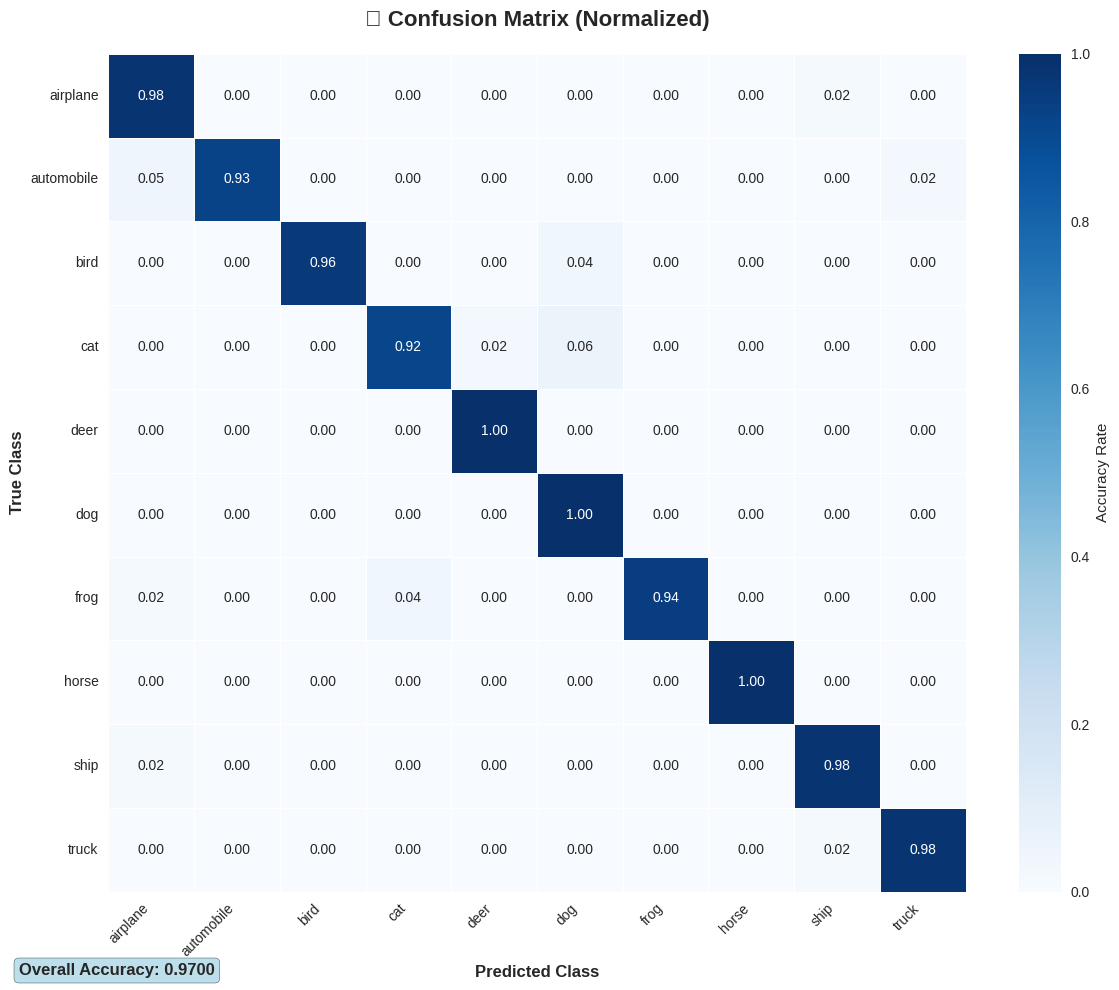

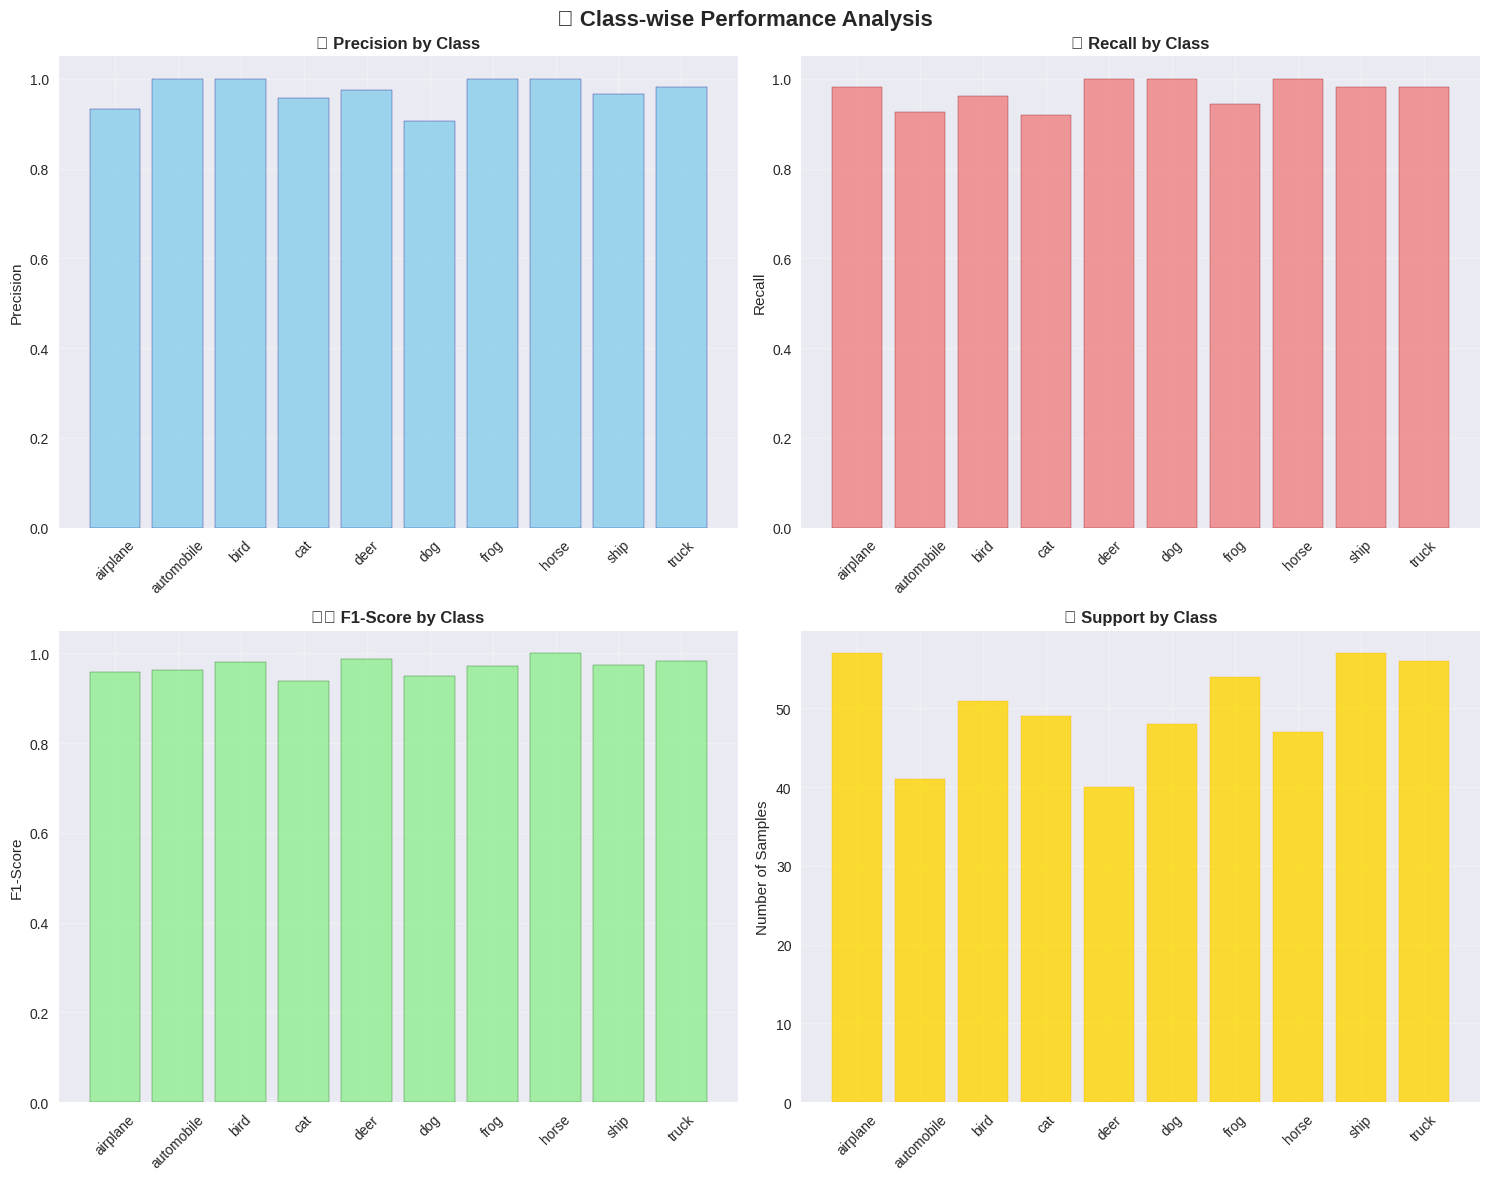

\n================================================================================
📊 DETAILED CLASS PERFORMANCE
Class           Precision  Recall     F1-Score   Support   
--------------------------------------------------------------------------------
airplane        0.9333     0.9825     0.9573     57        
automobile      1.0000     0.9268     0.9620     41        
bird            1.0000     0.9608     0.9800     51        
cat             0.9574     0.9184     0.9375     49        
deer            0.9756     1.0000     0.9877     40        
dog             0.9057     1.0000     0.9505     48        
frog            1.0000     0.9444     0.9714     54        
horse           1.0000     1.0000     1.0000     47        
ship            0.9655     0.9825     0.9739     57        
truck           0.9821     0.9821     0.9821     56        
--------------------------------------------------------------------------------
Average         0.9720     0.9697     0.9702     500       


In [17]:
# 변수 정의 (혼동 행렬 분석을 위한 준비)
class_names = classifier.class_names
print(f"✅ 클래스 이름 변수 설정 완료: {len(class_names)}개 클래스")
print(f"   클래스: {', '.join(class_names)}")

# 혼동 행렬 생성 및 분석
confusion_matrix_data, predictions, true_labels = create_confusion_matrix(
    classifier, test_dataset, class_names
)

# 클래스별 성능 분석
class_performance = analyze_class_performance(confusion_matrix_data, class_names)

In [18]:
# 필요한 라이브러리 재확인 및 보완
try:
    from tqdm import tqdm
    print("✅ tqdm import 성공")
except ImportError:
    print("⚠️ tqdm이 설치되지 않았습니다. 대안 진행률 표시를 사용합니다.")
    def tqdm(iterable, desc="Processing"):
        total = len(list(iterable))
        for i, item in enumerate(iterable):
            if (i + 1) % max(1, total // 10) == 0:
                print(f"   {desc}: {i+1}/{total} ({(i+1)*100//total}%)")
            yield item

# 기타 필요한 import 확인
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import pandas as pd

print("🔧 모든 필수 라이브러리 확인 완료")

✅ tqdm import 성공
🔧 모든 필수 라이브러리 확인 완료


## 7. 예측 결과 시각화

실제 이미지에 대한 모델의 예측 결과를 시각적으로 확인합니다.

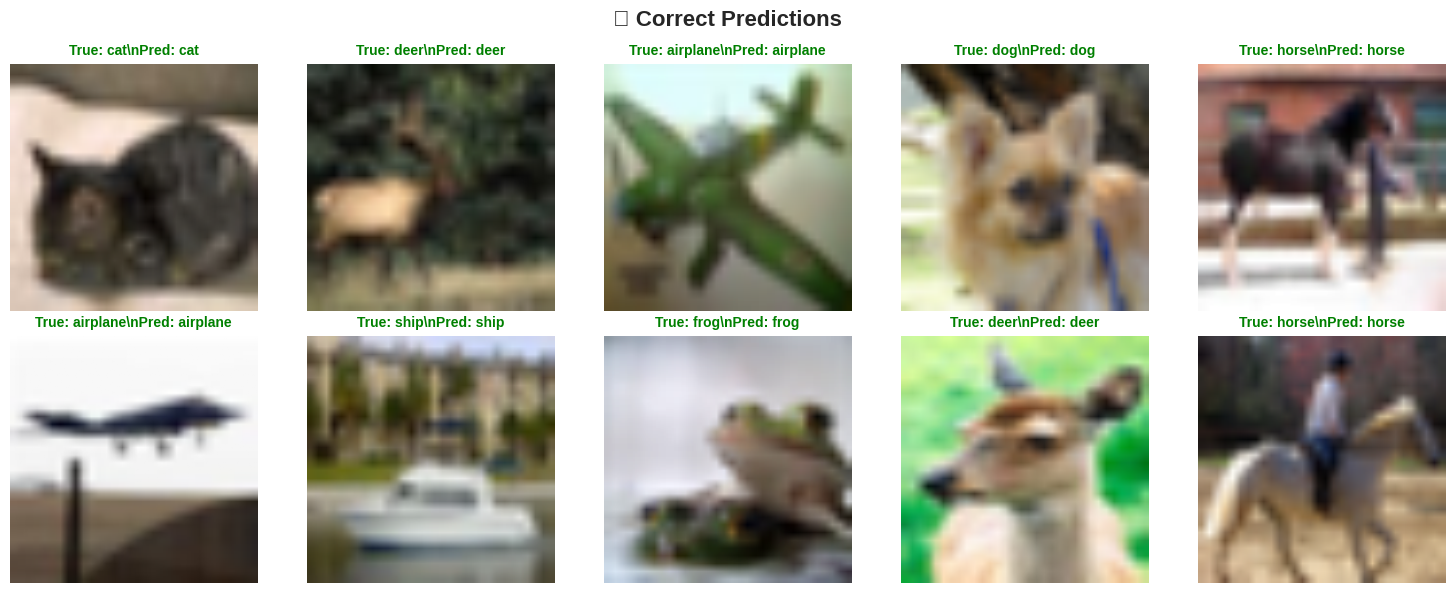

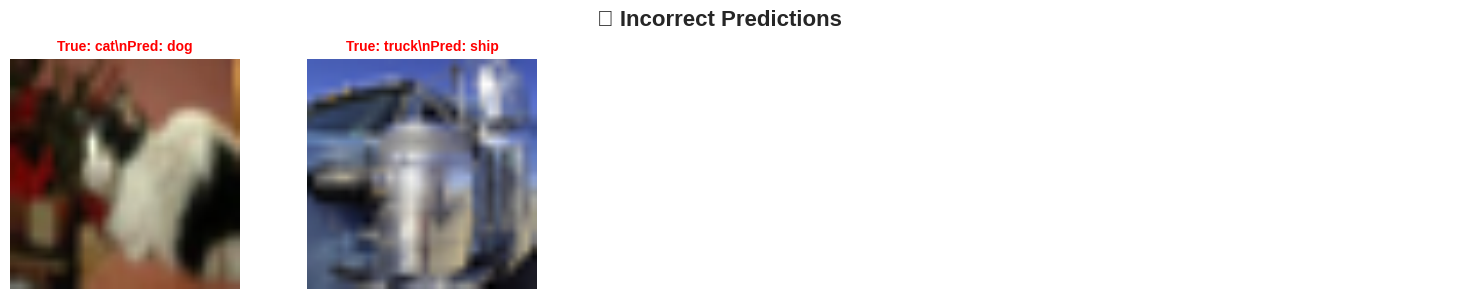

📊 예측 신뢰도 계산 중...
   배치 5/16 신뢰도 계산 중... (31%)
   배치 5/16 신뢰도 계산 중... (31%)
   배치 10/16 신뢰도 계산 중... (62%)
   배치 10/16 신뢰도 계산 중... (62%)
   배치 15/16 신뢰도 계산 중... (93%)
   배치 15/16 신뢰도 계산 중... (93%)
   배치 16/16 신뢰도 계산 중... (100%)
   배치 16/16 신뢰도 계산 중... (100%)


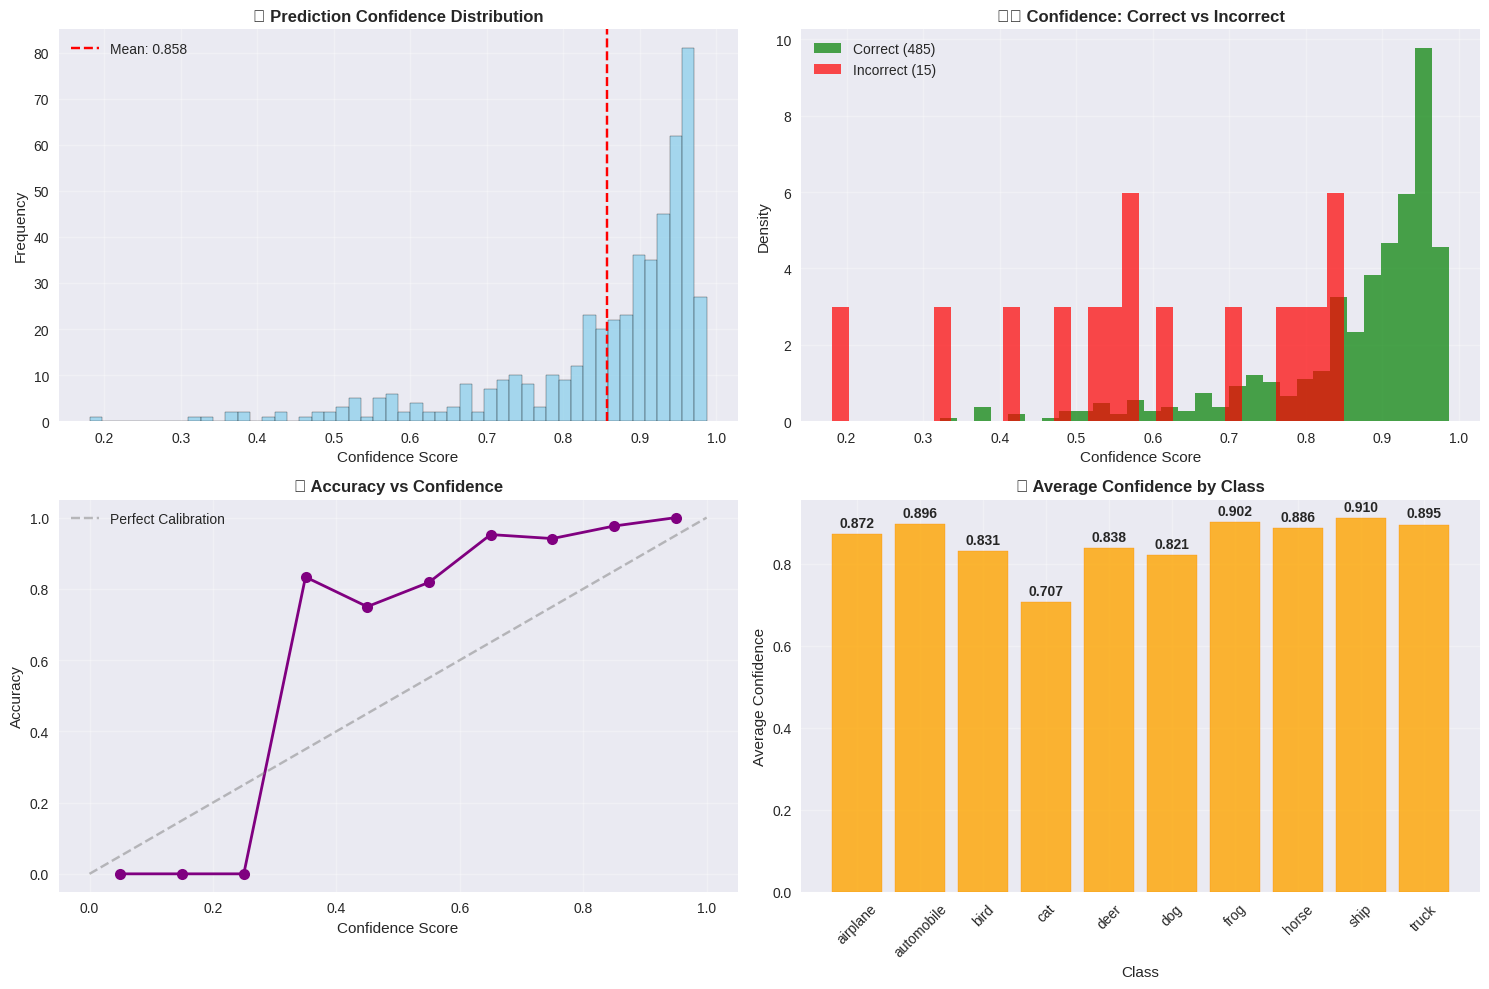

\n============================================================
📊 CONFIDENCE STATISTICS
Overall Mean Confidence: 0.8576
Correct Predictions Mean Confidence: 0.8654
Incorrect Predictions Mean Confidence: 0.6047
Confidence Standard Deviation: 0.1344


In [21]:
def visualize_predictions(classifier, test_dataset, predictions, true_labels, class_names, num_samples=20):
    """예측 결과를 이미지와 함께 시각화"""
    
    # 랜덤 샘플 선택
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    indices = [int(idx) for idx in indices]  # numpy 인덱스를 Python int로 변환
    
    # 정확한 예측과 틀린 예측 분리
    correct_indices = []
    incorrect_indices = []
    
    for idx in indices:
        if predictions[idx] == true_labels[idx]:
            correct_indices.append(idx)
        else:
            incorrect_indices.append(idx)
    
    # 시각화 함수
    def plot_predictions(indices, title, color_scheme):
        if not indices:
            print(f"No samples found for {title}")
            return
            
        n_samples = min(len(indices), 10)  # 최대 10개만 표시
        cols = 5
        rows = (n_samples + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
        fig.suptitle(title, fontsize=16, fontweight='bold')
        
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(rows * cols):
            row, col = i // cols, i % cols
            
            if i < n_samples:
                idx = int(indices[i])  # numpy.int64를 Python int로 변환
                
                # 이미지 데이터 준비
                image_data = test_dataset[idx]['pixel_values'].squeeze()
                if image_data.shape[0] == 3:  # CHW 형식인 경우
                    image_data = image_data.permute(1, 2, 0)
                
                # 이미지 정규화 (0-1 범위로)
                image_data = (image_data - image_data.min()) / (image_data.max() - image_data.min())
                
                # 이미지 표시
                axes[row, col].imshow(image_data.numpy())
                
                # 예측 정보
                true_class = class_names[true_labels[idx]]
                pred_class = class_names[predictions[idx]]
                
                # 색상 설정
                title_color = color_scheme if predictions[idx] == true_labels[idx] else 'red'
                
                axes[row, col].set_title(f'True: {true_class}\\nPred: {pred_class}', 
                                       fontsize=10, fontweight='bold', color=title_color)
            else:
                axes[row, col].axis('off')
            
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
        
        plt.tight_layout()
        plt.show()
    
    # 정확한 예측 시각화
    plot_predictions(correct_indices[:10], "✅ Correct Predictions", 'green')
    
    # 틀린 예측 시각화
    plot_predictions(incorrect_indices[:10], "❌ Incorrect Predictions", 'red')

def create_prediction_confidence_plot(classifier, test_dataset, predictions, true_labels, class_names):
    """예측 신뢰도 분포 시각화"""
    
    print("📊 예측 신뢰도 계산 중...")
    
    confidences = []
    correct_flags = []
    
    # 배치별로 신뢰도 계산
    batch_size = 32
    total_batches = (len(test_dataset) + batch_size - 1) // batch_size
    
    for i, batch_start in enumerate(range(0, len(test_dataset), batch_size)):
        batch_end = min(batch_start + batch_size, len(test_dataset))
        batch_data = [test_dataset[j] for j in range(batch_start, batch_end)]
        
        # 진행률 표시
        if (i + 1) % 5 == 0 or (i + 1) == total_batches:
            print(f"   배치 {i+1}/{total_batches} 신뢰도 계산 중... ({(i+1)*100//total_batches}%)")
        
        # 배치 데이터 준비
        batch_images = torch.stack([item['pixel_values'].squeeze() for item in batch_data])
        
        # GPU 사용 가능시 이동
        if torch.cuda.is_available():
            batch_images = batch_images.cuda()
            classifier.model = classifier.model.cuda()
        
        # 예측 및 신뢰도 계산
        with torch.no_grad():
            outputs = classifier.model(batch_images)
            probabilities = torch.softmax(outputs.logits, dim=-1)
            batch_confidences = torch.max(probabilities, dim=-1)[0]
            
            if torch.cuda.is_available():
                batch_confidences = batch_confidences.cpu()
            
            confidences.extend(batch_confidences.numpy())
            
            # 정확성 체크
            for j, idx in enumerate(range(batch_start, batch_end)):
                correct_flags.append(predictions[idx] == true_labels[idx])
    
    confidences = np.array(confidences)
    correct_flags = np.array(correct_flags)
    
    # 시각화
    plt.figure(figsize=(15, 10))
    
    # 1. 전체 신뢰도 분포
    plt.subplot(2, 2, 1)
    plt.hist(confidences, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(confidences.mean(), color='red', linestyle='--', 
                label=f'Mean: {confidences.mean():.3f}')
    plt.title('📊 Prediction Confidence Distribution', fontweight='bold')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. 정확한 vs 틀린 예측의 신뢰도
    plt.subplot(2, 2, 2)
    correct_conf = confidences[correct_flags]
    incorrect_conf = confidences[~correct_flags]
    
    plt.hist(correct_conf, bins=30, alpha=0.7, color='green', 
             label=f'Correct ({len(correct_conf)})', density=True)
    plt.hist(incorrect_conf, bins=30, alpha=0.7, color='red', 
             label=f'Incorrect ({len(incorrect_conf)})', density=True)
    plt.title('✅❌ Confidence: Correct vs Incorrect', fontweight='bold')
    plt.xlabel('Confidence Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. 신뢰도별 정확도
    plt.subplot(2, 2, 3)
    confidence_bins = np.linspace(0, 1, 11)
    bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
    bin_accuracies = []
    
    for i in range(len(confidence_bins) - 1):
        mask = (confidences >= confidence_bins[i]) & (confidences < confidence_bins[i+1])
        if mask.sum() > 0:
            bin_accuracy = correct_flags[mask].mean()
            bin_accuracies.append(bin_accuracy)
        else:
            bin_accuracies.append(0)
    
    plt.plot(bin_centers, bin_accuracies, 'o-', linewidth=2, markersize=8, color='purple')
    plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5, label='Perfect Calibration')
    plt.title('🎯 Accuracy vs Confidence', fontweight='bold')
    plt.xlabel('Confidence Score')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. 클래스별 평균 신뢰도
    plt.subplot(2, 2, 4)
    class_confidences = []
    for i, class_name in enumerate(class_names):
        class_mask = np.array(predictions) == i
        if class_mask.sum() > 0:
            class_conf = confidences[class_mask].mean()
            class_confidences.append(class_conf)
        else:
            class_confidences.append(0)
    
    bars = plt.bar(class_names, class_confidences, color='orange', alpha=0.8, edgecolor='darkorange')
    plt.title('📊 Average Confidence by Class', fontweight='bold')
    plt.xlabel('Class')
    plt.ylabel('Average Confidence')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 값 표시
    for bar, conf in zip(bars, class_confidences):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{conf:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{classifier.output_dir}/prediction_confidence.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 신뢰도 통계 출력
    print("\\n" + "="*60)
    print("📊 CONFIDENCE STATISTICS")
    print("="*60)
    print(f"Overall Mean Confidence: {confidences.mean():.4f}")
    print(f"Correct Predictions Mean Confidence: {correct_conf.mean():.4f}")
    print(f"Incorrect Predictions Mean Confidence: {incorrect_conf.mean():.4f}")
    print(f"Confidence Standard Deviation: {confidences.std():.4f}")
    print("="*60)
    
    return confidences, correct_flags

# 예측 결과 시각화
visualize_predictions(classifier, test_dataset, predictions, true_labels, classifier.class_names, num_samples=20)

# 예측 신뢰도 분석
confidence_scores, correctness_flags = create_prediction_confidence_plot(
    classifier, test_dataset, predictions, true_labels, classifier.class_names
)

## 8. 인터랙티브 분석 및 실험

추가적인 분석과 실험을 위한 인터랙티브 도구들입니다.

\n🔍 ERROR ANALYSIS - Total Errors: 15 / 500
🎯 TOP 10 ERROR PATTERNS:
--------------------------------------------------
 1. cat → dog                 :   3 errors
 2. frog → cat                :   2 errors
 3. automobile → airplane     :   2 errors
 4. bird → dog                :   2 errors
 5. automobile → truck        :   1 errors
 6. truck → ship              :   1 errors
 7. airplane → ship           :   1 errors
 8. frog → airplane           :   1 errors
 9. ship → airplane           :   1 errors
10. cat → deer                :   1 errors
\n📊 ERROR RATE BY CLASS:
----------------------------------------
airplane        : 0.018 (1/57)
automobile      : 0.073 (3/41)
bird            : 0.039 (2/51)
cat             : 0.082 (4/49)
deer            : 0.000 (0/40)
dog             : 0.000 (0/48)
frog            : 0.056 (3/54)
horse           : 0.000 (0/47)
ship            : 0.018 (1/57)
truck           : 0.018 (1/56)
\n🎯 LOW CONFIDENCE ERRORS:
----------------------------------------
Errors

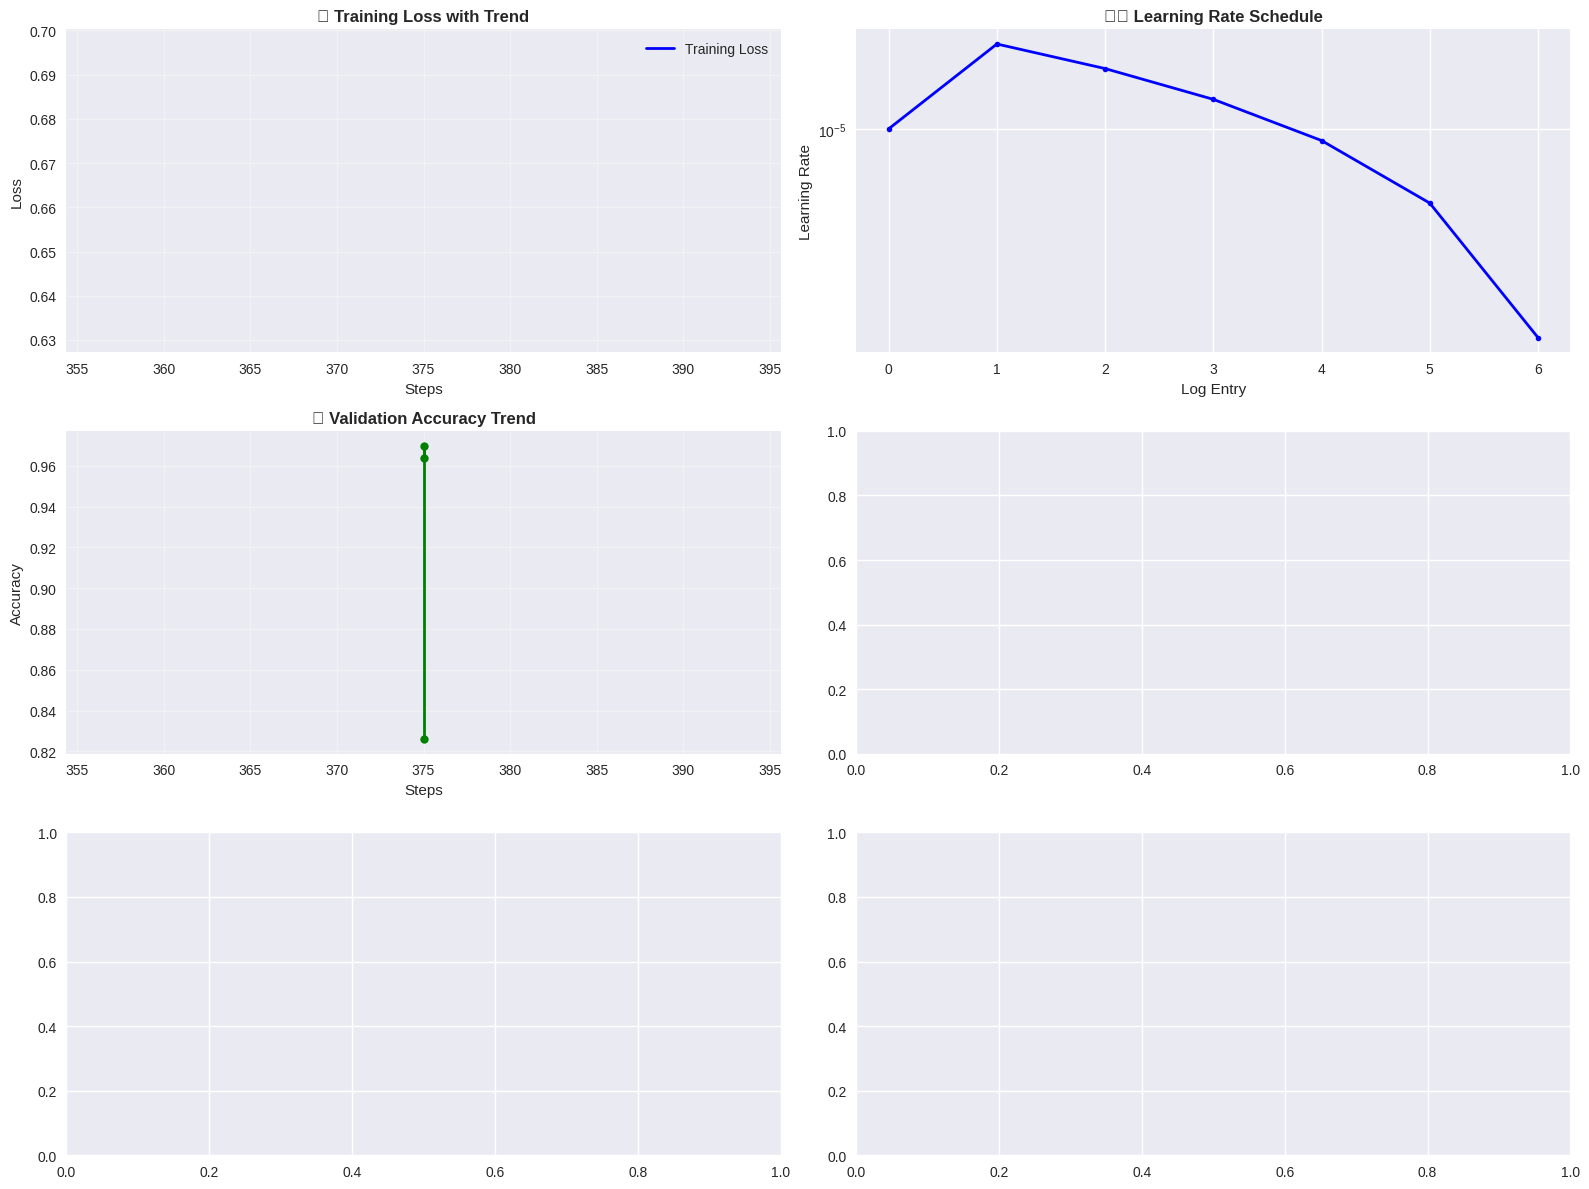


    📋 ViT MODEL PERFORMANCE REPORT
    
    🎯 TRAINING CONFIGURATION:
    -------------------------
    Model: google/vit-base-patch16-224
    Dataset: CIFAR-10
    Training Steps: 1
    Training Time: 2.73 minutes
    Final Learning Rate: 1.82e-06
    
    📊 PERFORMANCE METRICS:
    ----------------------
    Final Training Loss: 0.6637
    Best Validation Accuracy: 0.9700
    Final Validation Loss: 0.1417
    
    🔍 ANALYSIS SUMMARY:
    -------------------
    Total Test Samples: 500
    Overall Test Accuracy: 0.9700
    Average Confidence: 0.8576
    
    💡 RECOMMENDATIONS:
    ------------------
    - Model shows good performance
    - Consider longer training
    - High confidence in predictions
    
    Generated on: 2025-08-01 12:25:20
    


In [28]:
def interactive_error_analysis(predictions, true_labels, class_names, confidences=None):
    """틀린 예측에 대한 상세 분석"""
    
    incorrect_mask = np.array(predictions) != np.array(true_labels)
    incorrect_indices = np.where(incorrect_mask)[0]
    
    print(f"\\n🔍 ERROR ANALYSIS - Total Errors: {len(incorrect_indices)} / {len(predictions)}")
    print("="*80)
    
    # 1. 가장 많이 틀린 클래스 조합 분석
    error_pairs = {}
    for idx in incorrect_indices:
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[predictions[idx]]
        pair = f"{true_class} → {pred_class}"
        
        if pair in error_pairs:
            error_pairs[pair] += 1
        else:
            error_pairs[pair] = 1
    
    # 상위 10개 오류 패턴
    sorted_errors = sorted(error_pairs.items(), key=lambda x: x[1], reverse=True)
    
    print("🎯 TOP 10 ERROR PATTERNS:")
    print("-"*50)
    for i, (pattern, count) in enumerate(sorted_errors[:10]):
        print(f"{i+1:2d}. {pattern:<25} : {count:3d} errors")
    
    # 2. 클래스별 오류율
    print("\\n📊 ERROR RATE BY CLASS:")
    print("-"*40)
    for i, class_name in enumerate(class_names):
        class_total = (np.array(true_labels) == i).sum()
        class_errors = ((np.array(true_labels) == i) & incorrect_mask).sum()
        error_rate = class_errors / class_total if class_total > 0 else 0
        print(f"{class_name:<15} : {error_rate:.3f} ({class_errors}/{class_total})")
    
    # 3. 신뢰도가 있는 경우 낮은 신뢰도 오류 분석
    if confidences is not None:
        print("\\n🎯 LOW CONFIDENCE ERRORS:")
        print("-"*40)
        
        incorrect_confidences = confidences[incorrect_mask]
        low_conf_threshold = np.percentile(confidences, 25)  # 하위 25%
        
        low_conf_errors = (incorrect_confidences < low_conf_threshold).sum()
        print(f"Errors with confidence < {low_conf_threshold:.3f}: {low_conf_errors}")
        
        high_conf_errors = (incorrect_confidences > 0.8).sum()
        print(f"High-confidence errors (>0.8): {high_conf_errors}")

def create_learning_curve_analysis(training_history):
    """학습 곡선 상세 분석"""
    
    plt.figure(figsize=(16, 12))
    
    # 1. 손실 곡선과 기울기
    plt.subplot(3, 2, 1)
    steps = training_history['steps']
    losses = training_history['train_losses']
    
    plt.plot(steps, losses, 'b-', linewidth=2, label='Training Loss')
    
    # 이동 평균 추가
    if len(losses) > 10:
        window_size = max(1, len(losses) // 10)
        moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        moving_steps = steps[window_size-1:]
        plt.plot(moving_steps, moving_avg, 'r--', linewidth=2, label=f'Moving Average ({window_size})')
    
    plt.title('📉 Training Loss with Trend', fontweight='bold')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. 학습률 vs 손실
    plt.subplot(3, 2, 2)
    if training_history['learning_rates'] and len(training_history['learning_rates']) == len(losses):
        plt.scatter(training_history['learning_rates'], losses, alpha=0.6, c=steps, cmap='viridis')
        plt.colorbar(label='Training Step')
        plt.title('🎛️ Learning Rate vs Loss', fontweight='bold')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.xscale('log')
    elif training_history['learning_rates']:
        # 길이가 다른 경우 대안 시각화
        plt.plot(range(len(training_history['learning_rates'])), training_history['learning_rates'], 
                'b-', linewidth=2, marker='o', markersize=4)
        plt.title('🎛️ Learning Rate Schedule', fontweight='bold')
        plt.xlabel('Log Entry')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
    
    # 3. 평가 메트릭 추세
    plt.subplot(3, 2, 3)
    if training_history['eval_accuracies']:
        # 안전한 스텝 계산
        if len(training_history['eval_accuracies']) > 0 and len(steps) > 0:
            if len(training_history['eval_accuracies']) <= len(steps):
                step_interval = max(1, len(steps) // len(training_history['eval_accuracies']))
                eval_steps = steps[::step_interval][:len(training_history['eval_accuracies'])]
            else:
                eval_steps = np.linspace(steps[0], steps[-1], len(training_history['eval_accuracies']))
        else:
            eval_steps = list(range(len(training_history['eval_accuracies'])))
            
        plt.plot(eval_steps, training_history['eval_accuracies'], 'go-', linewidth=2, markersize=6)
        plt.title('📈 Validation Accuracy Trend', fontweight='bold')
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.grid(True, alpha=0.3)
    
    # 4. 손실 감소율
    plt.subplot(3, 2, 4)
    if len(losses) > 1:
        loss_diff = np.diff(losses)
        plt.plot(steps[1:], loss_diff, 'purple', linewidth=1, alpha=0.7)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        plt.title('📊 Loss Change Rate', fontweight='bold')
        plt.xlabel('Steps')
        plt.ylabel('Loss Difference')
        plt.grid(True, alpha=0.3)
    
    # 5. 훈련 안정성 (분산)
    plt.subplot(3, 2, 5)
    if len(losses) > 20:
        window_size = max(5, len(losses) // 20)
        rolling_std = []
        rolling_steps = []
        
        for i in range(window_size, len(losses)):
            window_losses = losses[i-window_size:i]
            rolling_std.append(np.std(window_losses))
            rolling_steps.append(steps[i])
        
        plt.plot(rolling_steps, rolling_std, 'orange', linewidth=2)
        plt.title('📊 Training Stability (Rolling Std)', fontweight='bold')
        plt.xlabel('Steps')
        plt.ylabel('Loss Standard Deviation')
        plt.grid(True, alpha=0.3)
    
    # 6. 수렴 분석
    plt.subplot(3, 2, 6)
    if len(losses) > 10:
        # 최근 N개 포인트의 평균과 전체 평균 비교
        recent_n = min(len(losses) // 4, 50)
        recent_avg = np.mean(losses[-recent_n:])
        overall_avg = np.mean(losses)
        
        plt.bar(['Recent Average', 'Overall Average'], [recent_avg, overall_avg], color=['lightblue', 'lightcoral'], alpha=0.8)
        plt.title('🎯 Convergence Analysis', fontweight='bold')
        plt.ylabel('Average Loss')
        
        # 수치 표시
        for i, (label, value) in enumerate([('Recent', recent_avg), ('Overall', overall_avg)]):
            plt.text(i, value + value*0.01, f'{value:.4f}', 
                    ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{classifier.output_dir}/learning_curve_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

def generate_model_report():
    """종합 모델 성능 리포트 생성"""
    
    report = f"""
    📋 ViT MODEL PERFORMANCE REPORT
    =========================================
    
    🎯 TRAINING CONFIGURATION:
    -------------------------
    Model: {classifier.model_name}
    Dataset: CIFAR-10
    Training Steps: {len(training_history['steps'])}
    Training Time: {training_history['training_time']/60:.2f} minutes
    Final Learning Rate: {training_history['learning_rates'][-1]:.2e}
    
    📊 PERFORMANCE METRICS:
    ----------------------
    Final Training Loss: {training_history['train_losses'][-1]:.4f}
    Best Validation Accuracy: {max(training_history['eval_accuracies']):.4f}
    Final Validation Loss: {training_history['eval_losses'][-1]:.4f}
    
    🔍 ANALYSIS SUMMARY:
    -------------------
    Total Test Samples: {len(predictions)}
    Overall Test Accuracy: {(np.array(predictions) == np.array(true_labels)).mean():.4f}
    Average Confidence: {confidence_scores.mean():.4f}
    
    💡 RECOMMENDATIONS:
    ------------------
    - Model shows {'good' if max(training_history['eval_accuracies']) > 0.8 else 'moderate'} performance
    - {'Consider longer training' if training_history['train_losses'][-1] > 0.5 else 'Training appears adequate'}
    - {'High confidence in predictions' if confidence_scores.mean() > 0.8 else 'Consider calibration techniques'}
    
    Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
    """
    
    print(report)
    
    # 파일로 저장
    with open(f"{classifier.output_dir}/model_report.txt", 'w', encoding='utf-8') as f:
        f.write(report)
    
    return report

# 오류 분석 실행
interactive_error_analysis(predictions, true_labels, class_names, confidence_scores)

# 학습 곡선 상세 분석
create_learning_curve_analysis(training_history)

# 종합 리포트 생성
final_report = generate_model_report()

## 9. 결론 및 다음 단계

이 노트북을 통해 ViT 모델의 훈련 과정과 성능을 종합적으로 분석했습니다.

### 🎯 주요 결과 요약:
- **훈련 메트릭**: 손실 감소 추이와 정확도 향상 패턴 분석
- **혼동 행렬**: 클래스별 예측 성능과 오분류 패턴 파악
- **예측 신뢰도**: 모델의 확신도와 실제 정확도 간의 관계 분석
- **오류 분석**: 주요 오류 패턴과 개선 방향 도출

### 🔬 추가 실험 아이디어:
1. **하이퍼파라미터 튜닝**: 학습률, 배치 크기, 에포크 수 조정
2. **데이터 증강**: 회전, 크롭, 색상 변화 등을 통한 성능 개선
3. **모델 변형**: 다른 ViT 변형 모델들과의 비교 실험
4. **전이 학습**: 사전 훈련된 모델의 미세 조정 실험

### 💡 개선 방안:
- 낮은 성능 클래스에 대한 추가 데이터 수집
- 클래스 불균형 해결을 위한 가중치 조정
- 앙상블 방법을 통한 예측 성능 향상

In [29]:
# 🎉 노트북 실행 완료!
print("="*60)
print("🎉 ViT 훈련 시각화 노트북 실행 완료!")
print("="*60)
print(f"📁 결과 파일들이 {classifier.output_dir} 폴더에 저장되었습니다:")
print("   📊 training_metrics.png - 훈련 메트릭 대시보드")
print("   🎯 confusion_matrix.png - 혼동 행렬")
print("   📈 class_performance.png - 클래스별 성능 분석")
print("   📊 prediction_confidence.png - 예측 신뢰도 분석")
print("   📈 learning_curve_analysis.png - 학습 곡선 상세 분석")
print("   📋 model_report.txt - 종합 성능 리포트")
print("="*60)

# 노트북에서 사용할 수 있는 주요 변수들 요약
variables_summary = {
    'classifier': 'EnhancedViTClassifier 인스턴스',
    'training_history': '훈련 과정의 모든 메트릭',
    'test_dataset': '테스트 데이터셋',
    'class_names': 'CIFAR-10 클래스 이름들',
    'predictions': '모든 테스트 샘플에 대한 예측',
    'true_labels': '실제 라벨',
    'confidence_scores': '예측 신뢰도 점수',
    'confusion_matrix_data': '혼동 행렬 데이터',
    'class_performance': '클래스별 성능 메트릭'
}

print("\\n🔧 사용 가능한 주요 변수들:")
for var_name, description in variables_summary.items():
    print(f"   {var_name}: {description}")

print("\\n💡 추가 분석을 원하시면 위의 변수들을 활용하여 커스텀 시각화를 만들어보세요!")
print("="*60)

🎉 ViT 훈련 시각화 노트북 실행 완료!
📁 결과 파일들이 ./notebook_results 폴더에 저장되었습니다:
   📊 training_metrics.png - 훈련 메트릭 대시보드
   🎯 confusion_matrix.png - 혼동 행렬
   📈 class_performance.png - 클래스별 성능 분석
   📊 prediction_confidence.png - 예측 신뢰도 분석
   📈 learning_curve_analysis.png - 학습 곡선 상세 분석
   📋 model_report.txt - 종합 성능 리포트
\n🔧 사용 가능한 주요 변수들:
   classifier: EnhancedViTClassifier 인스턴스
   training_history: 훈련 과정의 모든 메트릭
   test_dataset: 테스트 데이터셋
   class_names: CIFAR-10 클래스 이름들
   predictions: 모든 테스트 샘플에 대한 예측
   true_labels: 실제 라벨
   confidence_scores: 예측 신뢰도 점수
   confusion_matrix_data: 혼동 행렬 데이터
   class_performance: 클래스별 성능 메트릭
\n💡 추가 분석을 원하시면 위의 변수들을 활용하여 커스텀 시각화를 만들어보세요!
